In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *
import random
seed = 2022
random.seed(seed)

In [3]:
onto_paths = 'african-wildlife.ofn exchangemodel-noimport.ofn stuff-noimport.ofn swo-noimport.ofn ontodt-noimport.ofn pizza.ofn'.split()
onto_names = 'wildlife demacare stuff swo ontodt pizza'.split()
ontos = []
facts = []
for path in onto_paths:
    onto = load_ofn('local/out/dataset/' + path, silent=True)
    fact = Reasoner.from_onto(onto, timeout=None)
    facts.append(fact)
    ontos.append(onto)
    print(path, '\t', onto)

african-wildlife.ofn 	 <Onto 30 concepts, 5 roles, 49 axioms>
exchangemodel-noimport.ofn 	 <Onto 260 concepts, 53 roles, 369 axioms>
stuff-noimport.ofn 	 <Onto 192 concepts, 46 roles, 314 axioms>


FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


swo-noimport.ofn 	 <Onto 4067 concepts, 39 roles, 7140 axioms>
ontodt-noimport.ofn 	 <Onto 405 concepts, 8 roles, 921 axioms>
pizza.ofn 	 <Onto 99 concepts, 4 roles, 287 axioms>


In [4]:
def make_dataset(onto, fact, n_queries=16000, max_depth=4):
    rng = np.random.default_rng(seed)
    Nc, Nr = onto.n_concepts, onto.n_roles
    gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=max_depth, p_atomic=0.95)

    queries, answers, qset = [], [], set()
    while len(queries) < n_queries:
        axiom = gen()
        axiom_core = core(axiom)
        if axiom_core in qset: continue
        answer = fact.check_axiom(axiom)
        queries.append(axiom_core); answers.append(int(answer)); qset.add(axiom_core)
        
    return queries, answers

In [5]:
rng = np.random.default_rng(seed)
balances = {}
idx_tr, X_tr, y_tr = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    query_feature_length = 2
    X_tr_onto, y_tr_onto = make_dataset(onto, fact, 16000, query_feature_length)

    idx_tr += [i]*len(X_tr_onto)
    print(onto_name, '- balance', np.round(np.mean(y_tr_onto), 4))
    balances[onto_name] = np.round(np.mean(y_tr_onto), 4)
    X_tr += X_tr_onto
    y_tr += y_tr_onto
    
data_tr = idx_tr, X_tr, y_tr = jointshuffle(rng, idx_tr, X_tr, y_tr)

wildlife - balance 0.1216
demacare - balance 0.0445
stuff - balance 0.2646
swo - balance 0.3038
ontodt - balance 0.0848
pizza - balance 0.4474


In [6]:
def adjust_label_distribution(onto, fact, X, y, target_balance=0.1, query_length=3, max_iter=25):

    decay =0.96
    part =0.6
    tolerance = 0.015 if target_balance > 0.125 else 0.0075
    for i in range(max_iter):
        balance = np.mean(y)
        if abs(balance - target_balance) <= tolerance:
            break
        
        if balance > target_balance:
            majority_class = 1
        else:
            majority_class = 0
        
        excess =  int(part * y.count(majority_class))
        if excess == 0:
            continue
        
        indices = list(range(len(y)))
        indices_to_remove = random.sample([i for i, label in enumerate(y) if label == majority_class], excess)
        indices_to_keep = [i for i in indices if i not in indices_to_remove]
        
        X = [X[i] for i in indices_to_keep]
        y = [y[i] for i in indices_to_keep]
        
        num_to_add = len(indices_to_remove)
        if num_to_add > 0:
            X_new, y_new = make_dataset(onto, fact, num_to_add, query_length)
            X.extend(X_new)
            y.extend(y_new)
        part*=decay

    return X, y

In [7]:
idx_vl, X_vl, y_vl = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    query_feature_length = 7
    X_vl_onto, y_vl_onto = make_dataset(onto, fact, 3000, query_feature_length)
    X_vl_onto, y_vl_onto = adjust_label_distribution(onto, fact, X_vl_onto, y_vl_onto, balances[onto_name], query_feature_length)

    idx_vl += [i]*len(X_vl_onto)
    print(onto_name, '- balance', np.round(np.mean(y_vl_onto), 4))
    X_vl += X_vl_onto
    y_vl += y_vl_onto
    
data_vl = idx_vl, X_vl, y_vl = jointshuffle(rng, idx_vl, X_vl, y_vl)

wildlife - balance 0.12
demacare - balance 0.0497
stuff - balance 0.259
swo - balance 0.2977
ontodt - balance 0.0893
pizza - balance 0.4503


In [8]:
idx_te, X_te, y_te = [], [], []
query_feature_length = 7
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    X_te_onto, y_te_onto = make_dataset(onto, fact, 3000, query_feature_length)
    X_te_onto, y_te_onto = adjust_label_distribution(onto, fact, X_te_onto, y_te_onto, balances[onto_name], query_feature_length)

    idx_te += [i]*len(X_te_onto)
    print(onto_name, '- balance', np.round(np.mean(y_te_onto), 4))
    X_te += X_te_onto
    y_te += y_te_onto
    
data_te = idx_te, X_te, y_te = jointshuffle(rng, idx_te, X_te, y_te)

wildlife - balance 0.12
demacare - balance 0.0497
stuff - balance 0.259
swo - balance 0.2977
ontodt - balance 0.0893
pizza - balance 0.4503


In [9]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)


T.manual_seed(seed)
transfer_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_head = ModifiedReasonerHead(**head_params)
transfer_r_head.load_state_dict(T.load('local/out/exp/20240713T172501/reasoner.pt'))

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log = train_mod(data_tr, data_vl, transfer_r_head, transfer_r_embs, freeze_reasoner=True, run_name='frozen transfer', **train_params, identities_weight=0.038, identitity_weight_decay=0.91)


----
frozen reasoner head (transfer)
train epoch 00/10 | batch 3001/3000 | loss 1.3800 | val loss 1.7070 | acc 0.6038 | f1 0.3964 | prec 0.2921 | recall 0.6166 | roc auc 0.6603 | pr auc 0.3894 | elapsed 56.73s
train epoch 01/10 | batch 3001/3000 | loss 0.9577 | val loss 0.9726 | acc 0.7462 | f1 0.5517 | prec 0.4397 | recall 0.7401 | roc auc 0.8125 | pr auc 0.5454 | elapsed 1118.32s
train epoch 02/10 | batch 3001/3000 | loss 0.5579 | val loss 0.7831 | acc 0.7902 | f1 0.6110 | prec 0.5019 | recall 0.7809 | roc auc 0.8605 | pr auc 0.6168 | elapsed 1122.14s
train epoch 03/10 | batch 3001/3000 | loss 0.4194 | val loss 0.7050 | acc 0.8117 | f1 0.6423 | prec 0.5360 | recall 0.8012 | roc auc 0.8818 | pr auc 0.6563 | elapsed 1122.53s
train epoch 04/10 | batch 3001/3000 | loss 0.3501 | val loss 0.6639 | acc 0.8226 | f1 0.6611 | prec 0.5537 | recall 0.8202 | roc auc 0.8938 | pr auc 0.6824 | elapsed 1123.39s
train epoch 05/10 | batch 3001/3000 | loss 0.3047 | val loss 0.6413 | acc 0.8291 | f1 0.67

In [10]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)

T.manual_seed(seed)
transfer_r_orig_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_orig_head = ReasonerHead(**head_params)
transfer_r_orig_head.load_state_dict(T.load('local/out/exp/20240713T172026/reasoner.pt'))


print('frozen reasoner head (transfer) original')
T.manual_seed(seed)
transfer_log_orig = train(data_tr, data_vl, transfer_r_orig_head, transfer_r_orig_embs, freeze_reasoner=True, run_name='frozen transfer original', **train_params)


frozen reasoner head (transfer) original
train epoch 00/10 | batch 3001/3000 | loss 0.8691 | val loss 0.9282 | acc 0.6864 | f1 0.3336 | prec 0.3024 | recall 0.3720 | roc auc 0.6545 | pr auc 0.3469 | elapsed 41.62s
train epoch 01/10 | batch 3001/3000 | loss 0.5736 | val loss 0.5211 | acc 0.8008 | f1 0.4944 | prec 0.5322 | recall 0.4616 | roc auc 0.8013 | pr auc 0.5453 | elapsed 1077.72s
train epoch 02/10 | batch 3001/3000 | loss 0.3685 | val loss 0.4604 | acc 0.8275 | f1 0.5413 | prec 0.6166 | recall 0.4824 | roc auc 0.8364 | pr auc 0.6089 | elapsed 1087.64s
train epoch 03/10 | batch 3001/3000 | loss 0.3108 | val loss 0.4449 | acc 0.8366 | f1 0.5599 | prec 0.6485 | recall 0.4926 | roc auc 0.8498 | pr auc 0.6326 | elapsed 1072.89s
train epoch 04/10 | batch 3001/3000 | loss 0.2824 | val loss 0.4364 | acc 0.8399 | f1 0.5676 | prec 0.6600 | recall 0.4979 | roc auc 0.8578 | pr auc 0.6445 | elapsed 1075.04s
train epoch 05/10 | batch 3001/3000 | loss 0.2627 | val loss 0.4341 | acc 0.8399 | f1 

local/out/exp/20240714T030457
------
Frozen pre-trained reasoner head original
train time 10731.633014440536
           mean     std   micro
acc      0.8476  0.1048  0.8476
prec     0.7352  0.1010  0.6852
recall   0.4625  0.1028  0.5134
f1       0.5560  0.0692  0.5870
auc_roc  0.8233  0.0305  0.8695
auc_pr   0.6224  0.0661  0.6664
------
Frozen pre-trained reasoner head
train time 11228.83409833908
           mean     std   micro
acc      0.8423  0.0594  0.8423
prec     0.5273  0.1490  0.5884
recall   0.8312  0.0357  0.8404
f1       0.6365  0.1188  0.6922
auc_roc  0.8976  0.0375  0.9081
auc_pr   0.7214  0.0806  0.7287


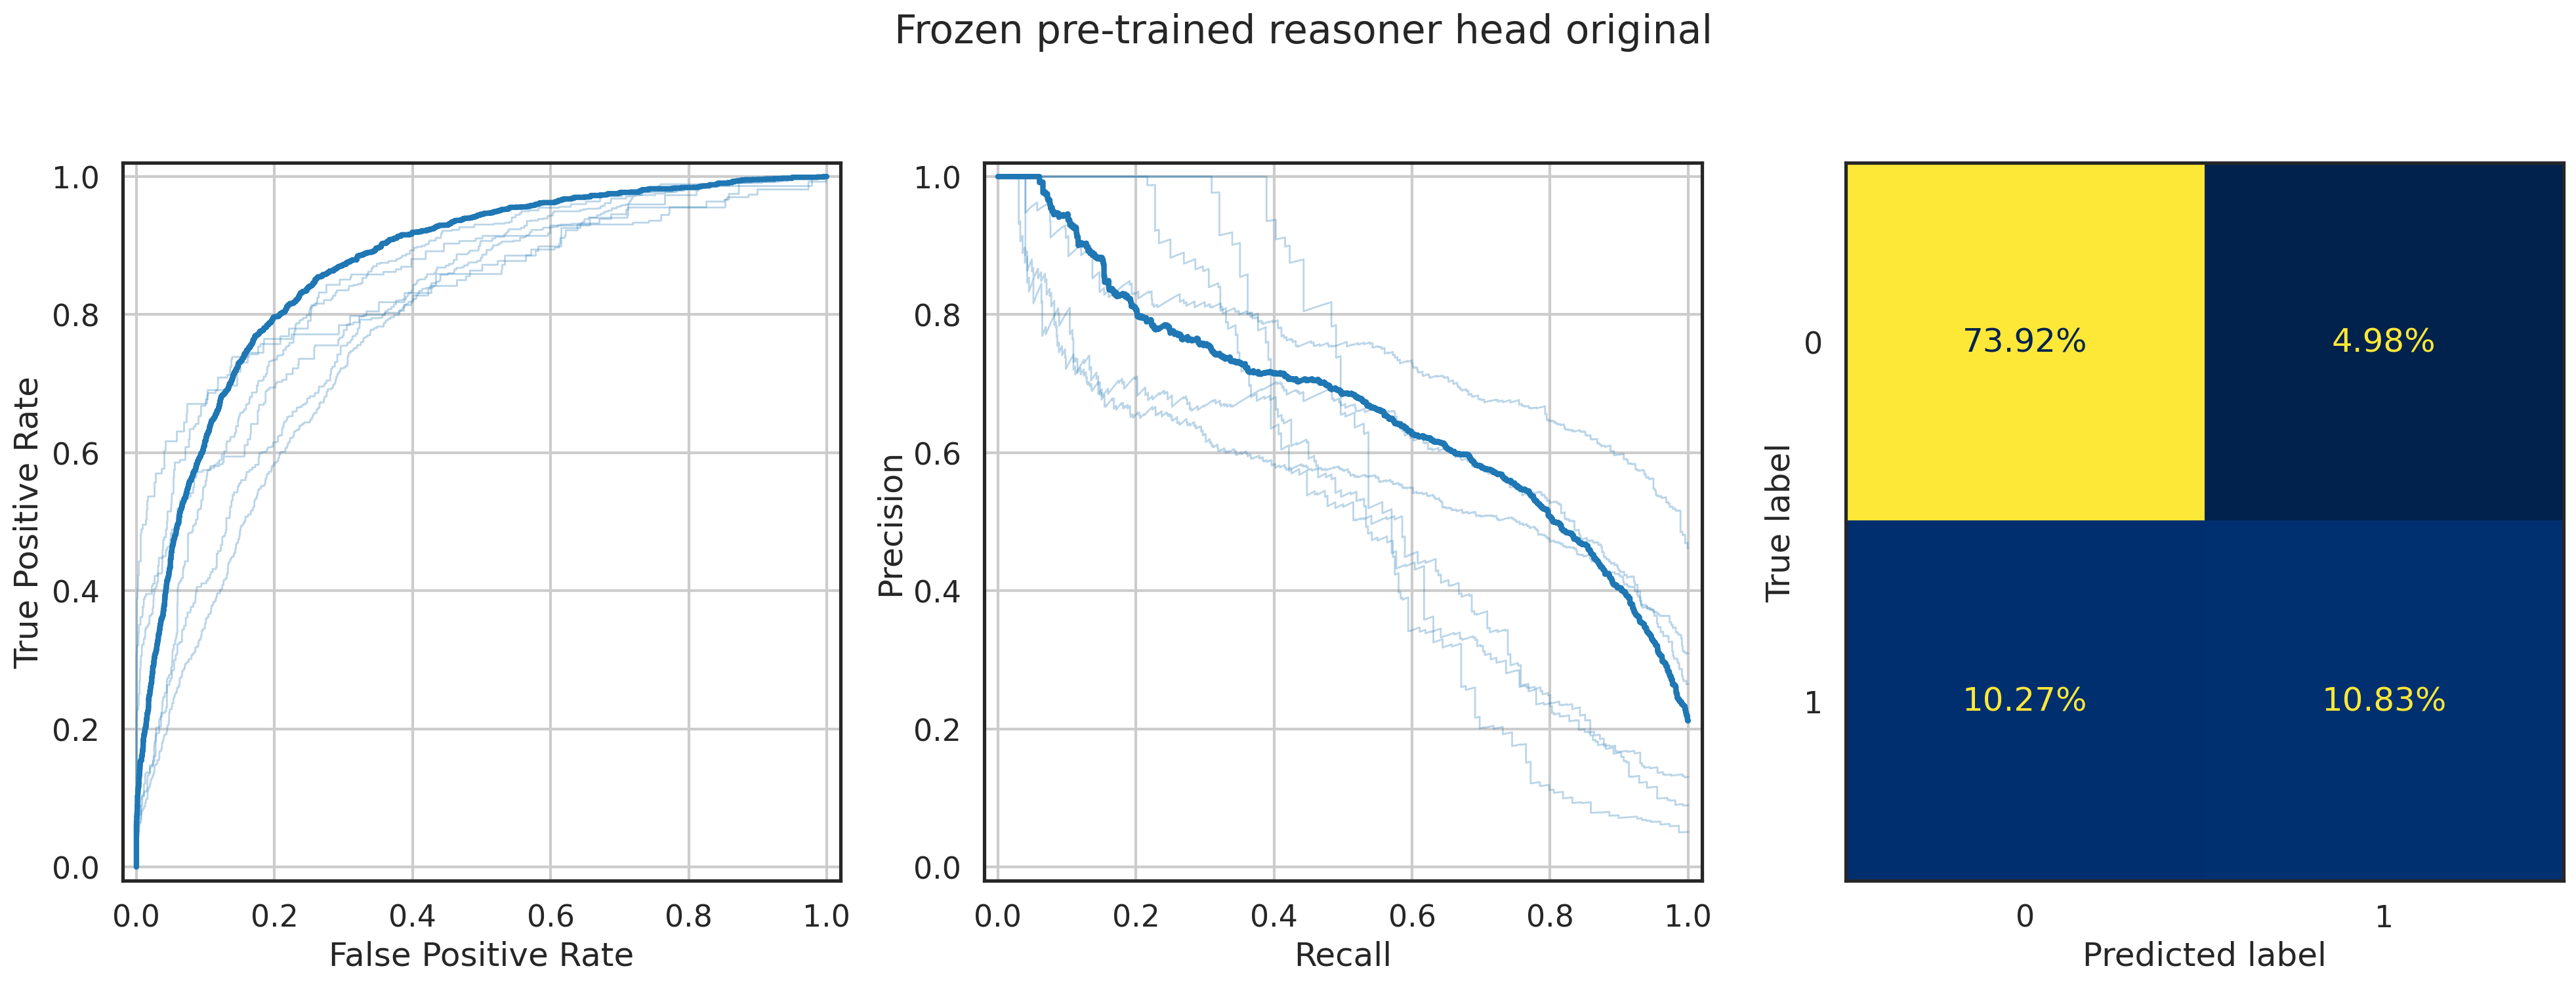

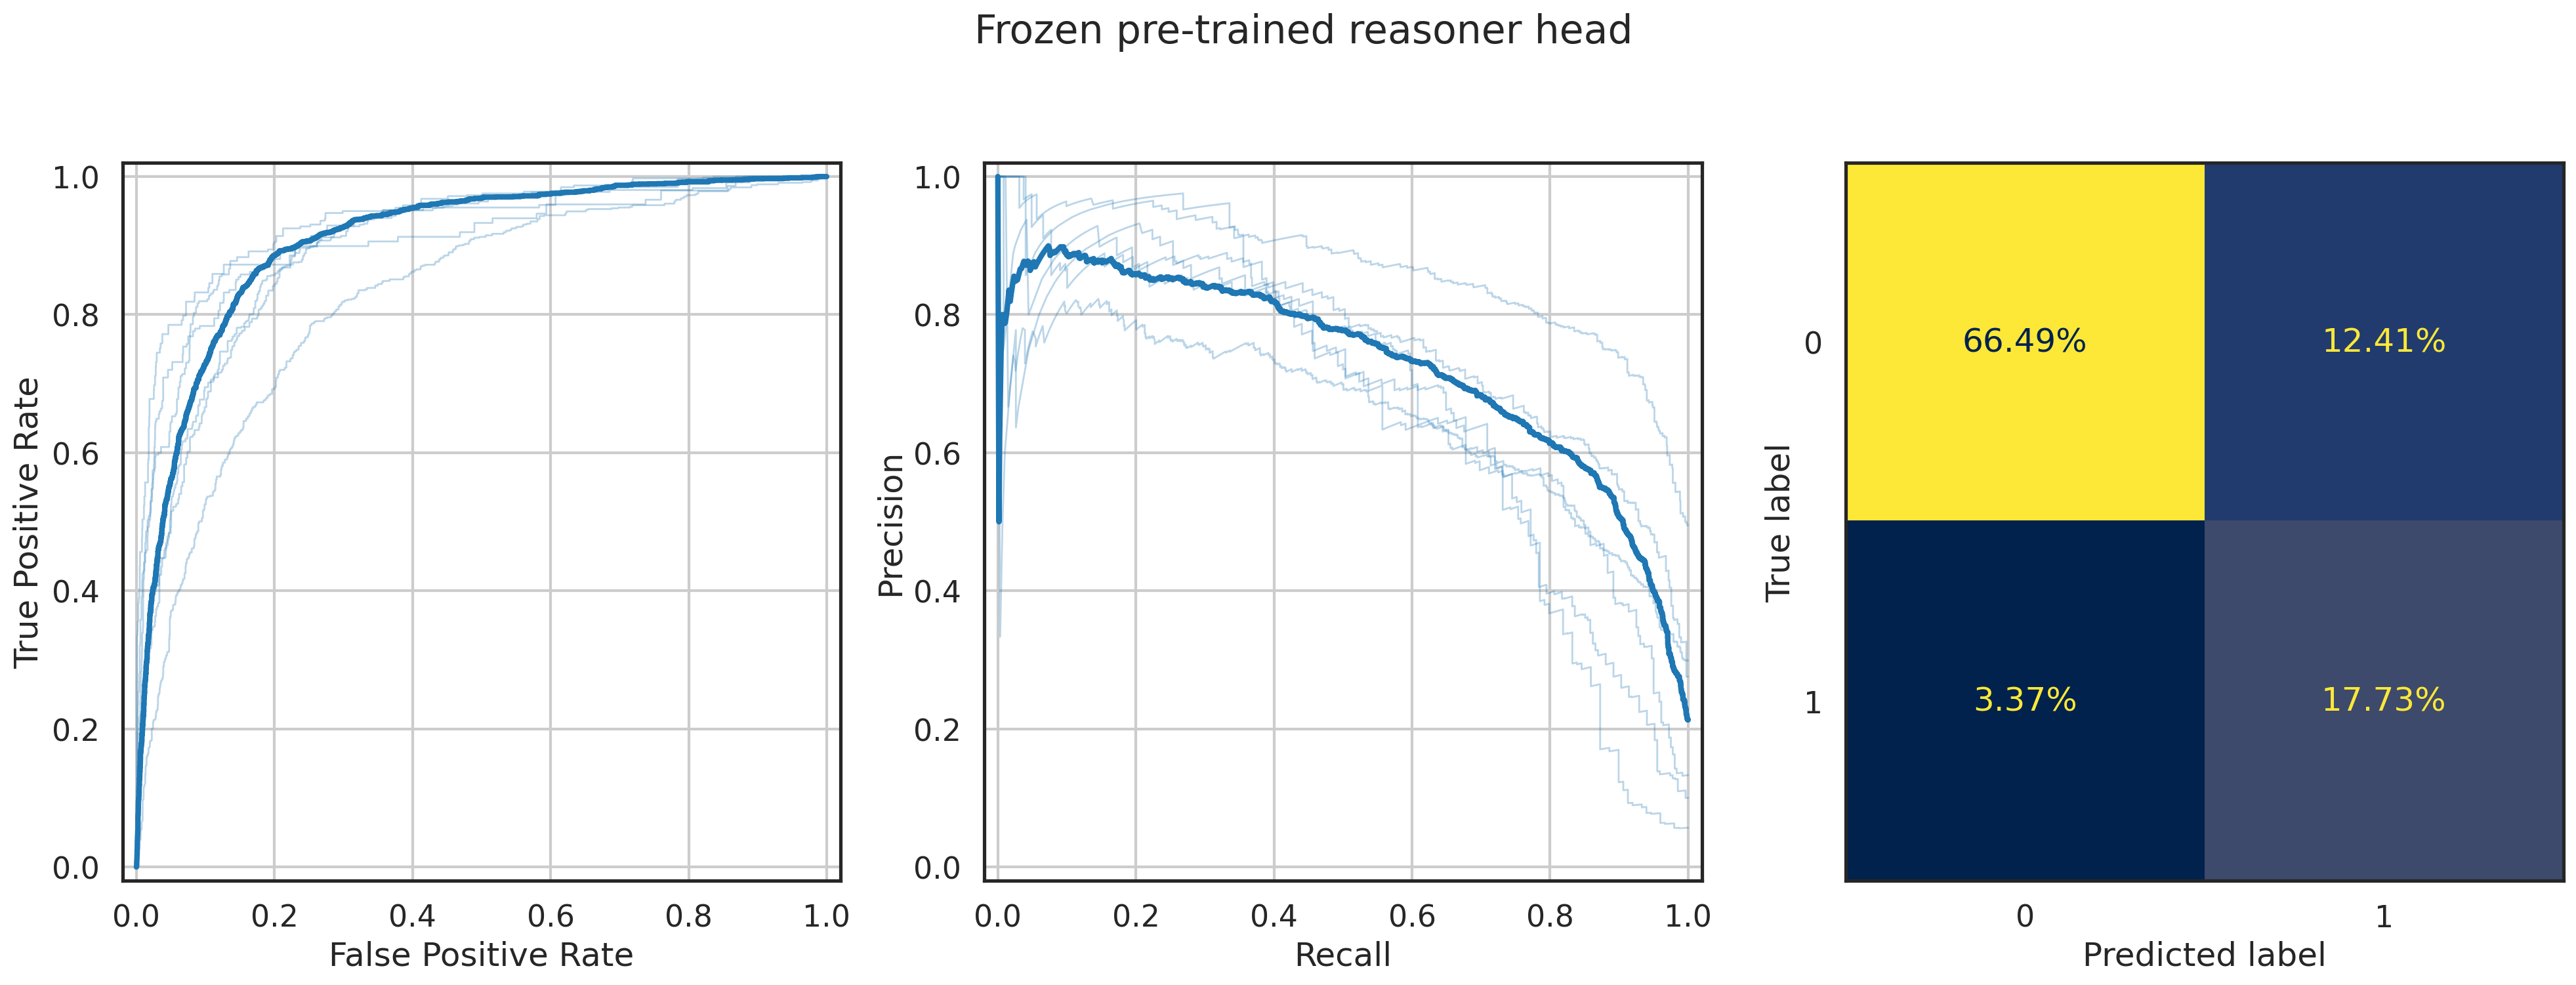

In [11]:
titles = 'Expected', 'Frozen pre-trained reasoner head original', 'Frozen pre-trained reasoner head'
logs = transfer_log_orig, transfer_log
heads = transfer_r_orig_head, transfer_r_head
embeddings = transfer_r_orig_embs, transfer_r_embs

base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    print('------')
    with T.no_grad():
        head.eval()
        if title == 'Frozen pre-trained reasoner head original':
            _, _, Y_te = eval_batch(head, embs, X_te, y_te, idx_te)
        else:
            _, _, Y_te = eval_batch_mod(head, embs, X_te, y_te, idx_te)

    print(title)
    
    history_tr = pd.DataFrame(log.history_tr)
    test_history_by_onto = pd.DataFrame(log.history_vl_by_onto)
    test_history = pd.DataFrame(log.history_vl)
    test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te=Y_te))
    test_history.to_csv(base+f'/{title} test.csv', index=False)
    test_history_by_onto.to_csv(base+f'/{title} test by onto.csv', index=False)
    test_results.to_csv(base+f'/{title} test clas.csv', index=False)

    print('train time', history_tr.groupby('epoch').max().elapsed.sum())
    print(report(ontos, y_te, Y_te, idx_te).round(4))
    plt.suptitle(title)

In [12]:
base = 'local/out/exp/' + 'exp5_frozen_new'
mkdirp(base)
T.save(transfer_r_embs, base+'/emb_mod_layer.pt')
T.save(transfer_r_orig_embs, base+'/emb_orig_layer.pt')

In [13]:
a = T.load(base+'/emb_orig_layer.pt')

In [14]:
b = T.load(base+'/emb_mod_layer.pt')

In [15]:
for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    df = pd.DataFrame(log.history_vl_by_onto)
    df = df[df.epoch == df.epoch.max()].drop(columns=['epoch', 'run', 'elapsed'])
    df.onto = df.onto.map(onto_names.__getitem__)
    print('-'*10)
    print(title)
    #print(df.agg(['mean', 'std']).round(4).T)
    print(df.round(4))

----------
Frozen pre-trained reasoner head original
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9107  0.4597  0.8382  0.3167   0.8201  0.5746  wildlife
61  0.9673  0.5739  0.8148  0.4430   0.8521  0.6014  demacare
62  0.8057  0.5897  0.6506  0.5393   0.8441  0.6231     stuff
63  0.7410  0.5282  0.5769  0.4871   0.7757  0.5817       swo
64  0.9377  0.5266  0.8189  0.3881   0.8557  0.6025    ontodt
65  0.7297  0.6710  0.7424  0.6121   0.8069  0.7626     pizza
----------
Frozen pre-trained reasoner head
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.8777  0.6267  0.4944  0.8556   0.9268  0.7036  wildlife
61  0.9130  0.4872  0.3444  0.8322   0.9185  0.6892  demacare
62  0.8223  0.7151  0.6115  0.8610   0.9041  0.7593     stuff
63  0.7457  0.6505  0.5504  0.7951   0.8241  0.6525       swo
64  0.8830  0.5447  0.4175  0.7836   0.9208  0.6646    ontodt
65  0.8200  0.8139  0.7614  0.8742   0.8957  0.8605     pizza


In [16]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te_2 = np.array(Y_te)
y_te_2 = np.array(y_te)
X_te_2 = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te_2 - y_te_2) > 0.5

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te_2[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rec': np.arange(len(X_te_2))[błędne_predykcje],
    'True': y_te_2[błędne_predykcje],
    'Pred': Y_te_2[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'F{i}' for i in range(X_te_2.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)



/tmp/ipykernel_17009/1003111826.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_te_2 = np.array(X_te)


In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', '{:0.2f}'.format):  # more options can be specified also
    print(wyniki)

        Rec  True  Pred F0                                                 F1  \
0        10     0  0.99  0  (4, (3, (7, 36, (4, (3, (4, (7, 5, (3, 228)), ...   
1        13     1  0.49  0  (3, (7, 2, (3, (4, (3, 3), (4, 65, (3, (4, 72,...   
2        15     1  0.10  0  (4, 2527, (7, 26, (3, (4, (3, (4, 3326, 839)),...   
3        17     0  0.97  0  (4, (4, (7, 45, (3, 82)), (3, (7, 28, (4, (3, ...   
4        30     0  1.00  0  (4, (4, (7, 23, (3, (4, (3, 91), (3, (7, 23, (...   
5        33     0  0.70  0  (4, (4, (4, 21, 24), (7, 1, (3, (7, 3, (7, 1, ...   
6        37     1  0.47  0                                               2391   
7        48     1  0.08  0                    (3, (7, 20, (7, 5, (3, 2722))))   
8        51     0  0.55  0  (3, (7, 15, (7, 12, (4, 55, (7, 43, (4, (3, (7...   
9        60     1  0.00  0                         (7, 2, (7, 0, (7, 7, -2)))   
10       64     0  0.90  0  (4, (7, 3, (7, 1, (7, 3, (3, 393)))), (4, (4, ...   
11       73     0  0.80  0  

In [18]:
T.sigmoid( transfer_r_head.encode( core(X_te[0]), transfer_r_embs[idx_te[0]]))


tensor([0.0230], grad_fn=<SigmoidBackward0>)

In [19]:
T.sigmoid(transfer_r_orig_head.encode( core(X_te[0]), transfer_r_embs[idx_te[0]]))


tensor([0.1417], grad_fn=<SigmoidBackward0>)

In [20]:
T.set_printoptions(precision=4)

In [21]:
import random

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_head.and_nn(im_mod( input, input)))
F.l1_loss(input, transfer_r_head.and_nn(im_mod(input, input)))

tensor([-0.0074, -0.0829,  0.0351, -0.0985,  0.0124, -0.0614, -0.1748, -0.1254,
         0.1624,  0.0753], grad_fn=<SelectBackward0>)
tensor([ 0.1416, -0.0778,  0.1426, -0.2144,  0.1712, -0.1103, -0.0783, -0.0873,
        -0.0321,  0.0605], grad_fn=<AddBackward0>)


tensor(0.0929, grad_fn=<L1LossBackward0>)

In [22]:
import random

encoder = transfer_r_orig_embs[int(np.round(random.random() * (len(transfer_r_orig_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_orig_head.and_nn(im_mod( input, input)))
F.l1_loss(input, transfer_r_orig_head.and_nn(im_mod(input, input)))

tensor([ 0.0059,  0.2261,  0.0519, -0.1605,  0.1036, -0.0229,  0.1544,  0.0958,
        -0.2162, -0.1486], grad_fn=<SelectBackward0>)
tensor([ 0.0841,  0.1324, -0.2116,  0.1838, -0.0493,  0.1717, -0.0838,  0.1228,
        -0.1711, -0.1869], grad_fn=<AddBackward0>)


tensor(0.1476, grad_fn=<L1LossBackward0>)

In [23]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.bot_concept[0])
print(transfer_r_head.and_nn(im_mod(transfer_r_head.bot_concept[0], input)))
print(F.l1_loss(transfer_r_head.and_nn(im_mod(transfer_r_head.bot_concept[0], input)), transfer_r_head.bot_concept[0]))

tensor([ 0.4583,  0.2395,  0.1590, -0.3344,  0.4590, -0.0595,  0.1135,  0.1671,
        -0.2914, -0.2250], grad_fn=<SelectBackward0>)
tensor([ 0.5351,  0.2051,  0.1498, -0.3675,  0.5352, -0.0511,  0.1375,  0.2259,
        -0.3335, -0.2984], grad_fn=<AddBackward0>)
tensor(0.0437, grad_fn=<L1LossBackward0>)


In [24]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_head.and_nn(im_mod(transfer_r_head.top_concept[0], input)))
print(F.l1_loss(transfer_r_head.and_nn(im_mod(transfer_r_head.top_concept[0], input)), input))

tensor([ 0.0037, -0.0091, -0.0129, -0.0177,  0.0050, -0.0774, -0.0995, -0.0327,
         0.0596, -0.0253], grad_fn=<SelectBackward0>)
tensor([ 0.0373, -0.0391,  0.0310, -0.0552,  0.0363, -0.0618, -0.0435, -0.0295,
         0.0068,  0.0120], grad_fn=<AddBackward0>)
tensor(0.0341, grad_fn=<L1LossBackward0>)


In [25]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.bot_concept[0])
output = transfer_r_head.and_nn(im_mod(transfer_r_head.not_nn(input), input))
print(output)
print(F.l1_loss(output, input))


tensor([ 0.4583,  0.2395,  0.1590, -0.3344,  0.4590, -0.0595,  0.1135,  0.1671,
        -0.2914, -0.2250], grad_fn=<SelectBackward0>)
tensor([ 0.1635, -0.1346,  0.1306, -0.2170,  0.1801, -0.1308, -0.0781, -0.1183,
        -0.0174,  0.0983], grad_fn=<AddBackward0>)
tensor(0.1538, grad_fn=<L1LossBackward0>)


In [26]:
print(transfer_r_head.bot_concept[0])
output = transfer_r_head.not_nn(transfer_r_head.top_concept[0])
print(output)
print(F.l1_loss(transfer_r_head.bot_concept[0], output))

tensor([ 0.4583,  0.2395,  0.1590, -0.3344,  0.4590, -0.0595,  0.1135,  0.1671,
        -0.2914, -0.2250], grad_fn=<SelectBackward0>)
tensor([ 0.5010,  0.2390,  0.1577, -0.3360,  0.4850, -0.0593,  0.1147,  0.1676,
        -0.3045, -0.2252], grad_fn=<SqueezeBackward3>)


tensor(0.0087, grad_fn=<L1LossBackward0>)


In [27]:
print(transfer_r_head.top_concept[0])
output = transfer_r_head.not_nn(transfer_r_head.bot_concept[0])
print(output)
print(F.l1_loss(transfer_r_head.top_concept[0], output))

tensor([-0.0591, -0.3377, -0.0532,  0.4513,  0.0746,  0.3900,  1.1205, -0.0056,
        -0.2022,  0.4371], grad_fn=<SelectBackward0>)
tensor([-0.0592, -0.3378, -0.0563,  0.4336,  0.0745,  0.3911,  1.0568, -0.0053,
        -0.2060,  0.4157], grad_fn=<SqueezeBackward3>)
tensor(0.0112, grad_fn=<L1LossBackward0>)


In [28]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input1 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input2 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input3 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.and_nn(im_mod(input2, input3)))))
print(transfer_r_head.and_nn(im_mod(transfer_r_head.and_nn(im_mod(input1, input2)), input3)))


F.mse_loss(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.and_nn(im_mod(input2, input3)))), transfer_r_head.and_nn(im_mod(transfer_r_head.and_nn(im_mod(input1, input2)), input3)))

tensor([ 0.1749, -0.0362,  0.1390, -0.2454,  0.2006, -0.0830, -0.0510, -0.0508,
        -0.0548,  0.0156], grad_fn=<AddBackward0>)
tensor([ 0.1786, -0.0818,  0.1513, -0.2225,  0.1921, -0.1127, -0.0595, -0.0493,
        -0.0612,  0.0300], grad_fn=<AddBackward0>)


tensor(0.0004, grad_fn=<MseLossBackward0>)

In [29]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.and_nn(im_mod(input1, input3)))
print(transfer_r_head.and_nn(im_mod(input3, input1)))

F.mse_loss(transfer_r_head.and_nn(im_mod(input1, input3)), transfer_r_head.and_nn(im_mod(input3, input1)))

F.mse_loss(transfer_r_head.and_nn(im_mod(input1, input3)), transfer_r_head.and_nn(im_mod(input3, input1)))

tensor([ 0.0861, -0.2157,  0.1423, -0.1768,  0.1034, -0.1396, -0.1213, -0.1786,
         0.0665,  0.1699], grad_fn=<AddBackward0>)
tensor([ 0.0975, -0.2329,  0.1447, -0.1777,  0.0922, -0.1304, -0.1345, -0.1749,
         0.0758,  0.1883], grad_fn=<AddBackward0>)


tensor(0.0001, grad_fn=<MseLossBackward0>)

In [30]:
print(input1)
print(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.top_concept[0])))

F.mse_loss(input1, transfer_r_head.and_nn(im_mod(input1, transfer_r_head.top_concept[0])))

tensor([-0.1244, -0.0855, -0.0461, -0.1073, -0.1299, -0.2016, -0.1863, -0.2894,
         0.2920,  0.0624], grad_fn=<SelectBackward0>)
tensor([-0.1090, -0.2141, -0.0069, -0.0151, -0.1210, -0.1276, -0.1408, -0.2033,
         0.2038,  0.1300], grad_fn=<AddBackward0>)


tensor(0.0054, grad_fn=<MseLossBackward0>)